In [1]:
import tdc
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from sklearn.manifold import TSNE
import pickle, sys

__독성 데이터 로드(Tox21, ToxCast 두 가지 합쳐서 사용)__

In [2]:
from tdc.utils import retrieve_label_name_list
from tdc.single_pred import Tox

label_list = retrieve_label_name_list('Toxcast')
label_list2 = retrieve_label_name_list('Tox21')
ToxCast = Tox(name = 'ToxCast', label_name = label_list[0])
Tox21 = Tox(name = 'Tox21', label_name = label_list2[0])

Found local copy...


Loading...
Done!
Found local copy...
Loading...
Done!


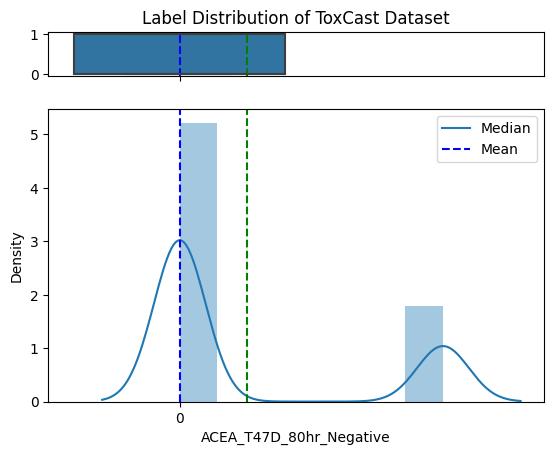

In [3]:
ToxCast.label_distribution()

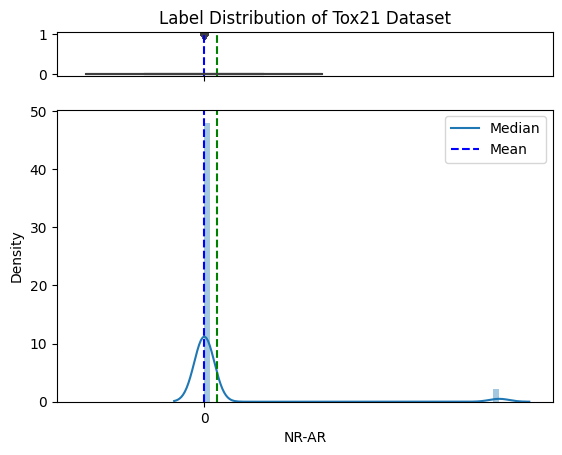

In [4]:
Tox21.label_distribution()

In [5]:
ToxCast_data = ToxCast.get_data()

In [6]:
Tox21_data = Tox21.get_data()

In [7]:
ToxCast_data

,Drug_ID,Drug,Y
0,Drug 0,O=[N+]([O-])c1ccc(Cl)cc1,0.0
1,Drug 3,Nc1ccc([N+](=O)[O-])cc1,1.0
2,Drug 4,O=[N+]([O-])c1ccc(O)cc1,0.0
3,Drug 11,OC[C@H]1O[C@@H]2O[C@@H]3[C@@H](CO)O[C@H](O[C@@...,0.0
4,Drug 15,O=C(O)c1ccc(C(=O)O)cc1,0.0
...,...,...,...
1726,Drug 8553,CCCOc1sc(C(=O)N2CCC(c3cc(CN)ccc3F)CC2)c(C)c1Br.Cl,1.0
1727,Drug 8554,O=C([O-])c1ccc2c(c1)nc(C(=O)NC1CCN(C3CC3)CC1)n...,0.0
1728,Drug 8555,CC(=O)O.COCCOc1cc2cc(C(=O)NC3CCN(C(C)C)CC3)n(C...,0.0
1729,Drug 8556,CC(=O)NC1(c2cccc(F)c2)CCN(CC[C@@]2(c3ccc(Cl)c(...,1.0


In [8]:
Tox21_data

,Drug_ID,Drug,Y
0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0
1,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O,0.0
2,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0
3,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0
4,TOX5110,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0.0
...,...,...,...
7260,TOX25184,CCCNCC(O)COc1ccccc1C(=O)CCc1ccccc1,0.0
7261,TOX2370,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...,1.0
7262,TOX2371,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...,1.0
7263,TOX2377,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,1.0


In [59]:
print('ToxCast_data 개수: ', len(ToxCast_data))
print('Tox21_data 개수: ', len(Tox21_data))

ToxCast_data 개수:  1731
Tox21_data 개수:  7265


### 독성 데이터 합치고 중복치 제거

In [62]:
Tox_data = pd.concat([Tox21_data, ToxCast_data])
Tox_data.drop(columns=['Drug_ID'], inplace=True)

In [70]:
Tox_data = Tox_data.reset_index(drop=True)

In [71]:
# 중복 데이터 개수
len(Tox_data[Tox_data.duplicated('Drug')])

404

In [72]:
Tox_data.drop_duplicates(inplace=True)
print('unique num of Tox_data: ', len(Tox_data))
print('라벨이 1인 데이터 개수: ', Tox_data['Y'].sum())

unique num of Tox_data:  7904
라벨이 1인 데이터 개수:  744.0


Tox21 + Toxcast 데이터셋에서 중복치 제거하 후 데이터 개수 : 7904

전체 데이터 개수 중 10% 가 '1' (1이 독성인지 무독성인지는 확인 필)

매우 imbalance한 데이터셋임

In [73]:
Tox_data

,Drug,Y
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0
2,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0
3,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0
4,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0.0
...,...,...
7899,CCCOc1sc(C(=O)N2CCC(c3cc(CN)ccc3F)CC2)c(C)c1Br.Cl,1.0
7900,O=C([O-])c1ccc2c(c1)nc(C(=O)NC1CCN(C3CC3)CC1)n...,0.0
7901,CC(=O)O.COCCOc1cc2cc(C(=O)NC3CCN(C(C)C)CC3)n(C...,0.0
7902,CC(=O)NC1(c2cccc(F)c2)CCN(CC[C@@]2(c3ccc(Cl)c(...,1.0


In [77]:
Tox_data.to_csv('Tox_data.csv', index=False)